In [34]:


%matplotlib inline
from itertools import chain

from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
import nest_asyncio
nest_asyncio.apply()
import importlib
from matplotlib import pyplot as plt
from typing import Any
from pathlib import Path
from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()
from collections import defaultdict

from sklearn import metrics


In [2]:

from tensorflow_probability.substrates.jax import tf2jax as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-12-03 15:48:39.715031: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:48:39.717534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:48:39.724145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733240919.734904 1348661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733240919.738055 1348661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 15:48:39.750650: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
with importlib.resources.path('bayesianquilts', 'data') as data_path:
    roach_path = data_path / "roachdata.csv"
    df = pd.read_csv(roach_path)

In [4]:


y_ = (df['y']>0).astype(int)
X_ = df.iloc[:, 2:]
X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(262, 4)


In [5]:
with importlib.resources.path('bayesianquilts', 'stanmodels') as data_path:
    model_path = data_path / "horseshoe_logistic.stan"
    sm = CmdStanModel(stan_file=model_path)

In [9]:
guessnumrelevcov = 10 # 20.
slab_scale = 2.5/100
scale_icept = 5.0
nu_global = 1
nu_local = 1
slab_df = 1
scale_global = guessnumrelevcov / ((d - guessnumrelevcov) * np.sqrt(N))/10000

control = {"adapt_delta": 0.9995, "max_treedepth": 15}

roach_data = {
    "N": N,
    "d": d,
    "slab_df": slab_df,
    "slab_scale": slab_scale,
    "scale_icept": scale_icept,
    "nu_global": 1,
    "nu_local": 1,
    "scale_global": np.abs(scale_global),
    "y": y_.astype(int)[:].tolist(),
    "x": X_scaled.tolist(),
}

import json
with open(f"{importlib.resources.path('bayesianquilts', 'data')}/roach_data.json", 'w') as f:
    json.dump(roach_data, f)

In [10]:
fit = sm.sample(
    data=f"{importlib.resources.path('bayesianquilts', 'data')}/roach_data.json",
    iter_warmup=20000,
    iter_sampling=2000,
    thin=2,
    adapt_delta=0.9995,
    max_treedepth=15,
)

15:48:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |          | 00:00 Iteration:     1 / 22000 [  0%]  (Warmup)



chain 1 |▏         | 00:00 Iteration:   200 / 22000 [  0%]  (Warmup)


chain 1 |▏         | 00:00 Iteration:   300 / 22000 [  1%]  (Warmup)
chain 1 |▎         | 00:01 Iteration:   400 / 22000 [  1%]  (Warmup)




chain 1 |▎         | 00:01 Iteration:   500 / 22000 [  2%]  (Warmup)


chain 1 |▎         | 00:01 Iteration:   600 / 22000 [  2%]  (Warmup)


chain 1 |▍         | 00:01 Iteration:   700 / 22000 [  3%]  (Warmup)


chain 1 |▍         | 00:01 Iteration:   800 / 22000 [  3%]  (Warmup)

chain 1 |▍         | 00:02 Iteration:   900 / 22000 [  4%]  (Warmup)


chain 1 |▌         | 00:02 Iteration:  1000 / 22000 [  4%]  (Warmup)


chain 1 |▌         | 00:02 Iteration:  1100 / 22000 [  5%]  (Warmup)


chain 1 |▋         | 00:02 Iteration:  1200 / 22000 [  5%]  (Warmup)


chain 1 |▋         | 00:02 Iteration:  1300 / 22000 [  5%


15:50:11 - cmdstanpy - INFO - CmdStan done processing.


In [13]:
params = fit.stan_variables()
params.keys()
params['c'] = params['c'][:, tf.newaxis]
params['tau'] = params['tau'][:, tf.newaxis]
params['caux'] = params['caux'][:, tf.newaxis]
params['beta0'] = params['beta0'][:, tf.newaxis]


In [14]:
lr_model = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [15]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = N
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

1it [00:00, 61.20it/s]


(0.0, 1.0)

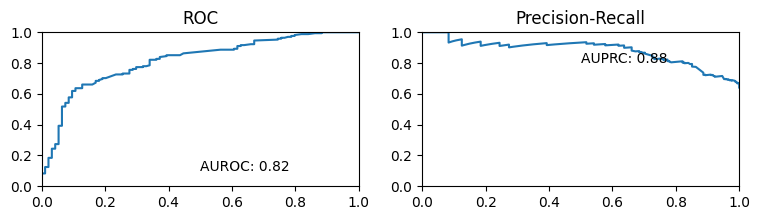

In [20]:
def prediction_fn(data):
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [24]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(
    self: LogisticRegression2,
    data: dict[str, tf.Tensor],
    params,
    hbar=1.0,
    variational=True,
) -> dict[str, Any]:
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    c = self.slab_scale * tf.math.sqrt(params["caux"])
    lambda_tilde = tf.math.sqrt(
        c**2
        * params["lambda"] ** 2
        / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
    )
    beta = params["z"] * lambda_tilde * params["tau"]
    intercept = params["beta0"]
    _X = tf.cast(data["X"], self.dtype)
    _y = tf.cast(data["y"], self.dtype)
    mu = beta[..., tf.newaxis, :] * _X
    mu = tf.reduce_sum(mu, -1) + params["beta0"]
    sigma = tf.math.sigmoid(mu)
    ell = _y * (sigma) + (1 - _y) * (1 - sigma)
    log_ell = tf.math.xlogy(_y, sigma) + tf.math.xlogy(1 - _y, 1 - sigma)
    log_ell_prime = _y * (1 - sigma) - (1 - _y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    ndx_to_transform = np.where(khat0 > 0.7)[0]
    ndx_to_leave = np.where((khat0 <= 0.7))[0]

    def IS(T, X, y):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        # compute # \nabla\log\pi(\btheta|\calD)
        if variational:
            # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
            grad_log_pi = tf.concat(
                [
                    -(
                        intercept
                        - self.surrogate_distribution.model["intercept__"].mean()
                    )
                    / self.surrogate_distribution.model["intercept__"].variance(),
                    -(beta - self.surrogate_distribution.model["beta__"].mean())
                    / self.surrogate_distribution.model["beta__"].variance(),
                ],
                axis=-1,
            )
            intercept_sd = (
                self.surrogate_distribution.model["intercept__"].variance() ** 0.5
            )
            beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

            log_pi = self.surrogate_distribution.model["beta__"].log_prob(
                params["beta__"]
            ) + self.surrogate_distribution.model["intercept__"].log_prob(
                params["intercept__"]
            )
            log_pi -= tf.reduce_max(log_pi, axis=0)
            # log_pi.shape: [samples]
        else:
            """
            Recall Bayes rule:
            \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

            so
            \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

            """
            log_prior = self.prior_distribution.log_prob_parts(params)
            log_prior = log_prior["z"] + log_prior["beta0"]

            log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]

            # pi \propto
            grad_log_pi = tf.concat(
                [
                    tf.reduce_sum(
                        log_ell_prime[..., tf.newaxis], axis=1, keepdims=True
                    ),
                    tf.reduce_sum(
                        log_ell_prime[..., tf.newaxis] * X, axis=1, keepdims=True
                    ),
                ],
                axis=-1,
            )

            grad_log_prior = -0.5 * tf.concat(
                [(params["beta0"] / self.scale_icept) ** 2, (params["z"]) ** 2],
                axis=-1,
            )
            grad_log_pi += grad_log_prior[:, tf.newaxis, :]

            intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
            beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

        beta_new, intercept_new, logJ = T(
            X,
            y,
            log_pi=log_pi,
            grad_log_pi=grad_log_pi,
            beta_sd=beta_sd,
            intercept_sd=intercept_sd,
        )
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.sqrt(
            c**2
            * params["lambda"] ** 2
            / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
        )
        transformed = params.copy()
        transformed["z"] = beta_new / (
            lambda_tilde[:, tf.newaxis, :] * params["tau"][..., tf.newaxis]
        )
        transformed["beta0"] = intercept_new

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * X, -1) + intercept_new
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob_parts(transformed)
            log_prior_new = log_prior_new["z"] + log_prior_new["beta0"]
            log_pi_new = ell_cross
            delta_log_prior = log_prior_new - log_prior[:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior

        # regularize delta_log_pi

        def regularize(tensor):
            min_finite = tf.reduce_min(
                tf.where(
                    tf.math.is_finite(tensor),
                    tensor,
                    jnp.zeros_like(tensor),
                )
            )
            return tf.where(
                tf.math.is_finite(tensor),
                tensor,
                min_finite * jnp.ones_like(tensor),
            )

        delta_log_pi = regularize(delta_log_pi)
        delta_log_pi -= tf.reduce_max(delta_log_pi, axis=0)
        log_eta_weights = delta_log_pi - regularize(log_ell_new) + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    # log-likelihood descent

    def T_ll(X, y, log_pi, beta_sd, intercept_sd, **kwargs):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma

        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta[..., tf.newaxis, :] + h * Q_beta
        intercept_ll = intercept[..., tf.newaxis, :] + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl(X, y, log_pi, grad_log_pi, beta_sd, intercept_sd):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * X
        Q_intercept = (
            ((-1) ** y) * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )
        dQ *= (
            grad_log_pi[..., 0]
            + (1 - 2 * y)[tf.newaxis, :]
            + tf.reduce_sum(
                X
                * (
                    grad_log_pi[..., 1:]
                    + (1 - 2 * y)[:, tf.newaxis] * X[tf.newaxis, ...]
                ),
                axis=-1,
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_I(X, y, **kwargs):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        Q = jnp.zeros_like(log_ell)
        return (
            beta[:, tf.newaxis, :] + Q[..., tf.newaxis],
            intercept[..., tf.newaxis] + Q[..., tf.newaxis],
            jnp.zeros_like(Q),
        )

    def T_var(X, y, log_pi, grad_log_pi, beta_sd, intercept_sd, **kwargs):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * X
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(
                log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :])
            )
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis, :] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_MM1(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = beta[:, tf.newaxis, ...] + hbar * (-beta_hat + beta_hat_w)
        beta0_adj = params["beta0"][:, tf.newaxis, ...] + hbar * (
            -beta0_hat + beta0_hat_w
        )

        # shift by mean
        return beta_adj, beta0_adj, jnp.zeros_like(ell)

    def T_MM2(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = beta[:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(beta_v_w / beta_v) - 1) * beta[:, tf.newaxis, ...]
            - tf.math.sqrt(beta_v_w / beta_v) * beta_hat
            + beta_hat_w
        )
        beta0_adj = params["beta0"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(beta0_v_w / beta0_v) - 1)
            * params["beta0"][:, tf.newaxis, ...]
            - tf.math.sqrt(beta0_v_w / beta0_v) * beta0_hat
            + beta0_hat_w
        )

        lJ = tf.math.log(
            1
            + hbar
            * (
                beta.shape[-1]
                * jnp.ones_like(ell)
                * (tf.math.sqrt(beta0_v_w / beta0_v) - 1)[..., 0]
            )
        )
        lJ += tf.math.log(1 + hbar * (tf.math.sqrt(beta0_v_w / beta0_v) - 1)[..., 0])

        # shift by mean
        return beta_adj, beta0_adj, lJ

    X_ = tf.gather(_X, ndx_to_leave)
    y_ = tf.gather(_y, ndx_to_leave)
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I, X_, y_)

    out = {
        "I0": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
            "ndx": ndx_to_leave,
        }
    }

    transforms = {
        "MM1": T_MM1,
        "MM2": T_MM2,
        "I": T_I,
        "KL": T_kl,
        "Var": T_var,
        "LL": T_ll,
    }

    X_ = tf.gather(_X, ndx_to_transform)
    y_ = tf.gather(_y, ndx_to_transform)
    for lab, fun in transforms.items():
        (
            eta_,
            eta_psis_,
            p_loo_,
            p_loo_sd_,
            ll_loo_,
            ll_loo_s_d,
            S_,
            k_,
            p_psis_,
            ll_psis_,
        ) = IS(fun, X_, y_)

        out = {
            **out,
            lab: {
                "p_loo": p_loo_,
                "p_loo_sd": p_loo_sd_,
                "ll_loo": ll_loo_,
                "ll_loo_sd": ll_loo_s_d,
                "S": S_,
                "khat": k_,
                "p_psis": p_psis_,
                "ll_psis": ll_psis_,
                "ndx": ndx_to_transform,
            },
        }

    return {**out, "ndx_transformed": ndx_to_transform}


nparams = 64
loo = adaptive_is_loo(
    lr_model,
    batch,
    {k: v[:nparams, ...] for k, v in params.items()},
    1e-5,
    variational=False,
)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var", "MM1", "MM2"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

I: 0.004396029253299099 entropy: 2.0303335277562113 khat>0.7: 1
LL: 0.004403387138502932 entropy: 2.030292506563469 khat>0.7: 1
KL: 0.004403390526185325 entropy: 2.030292489096836 khat>0.7: 1
Var: 0.004398148257397157 entropy: 2.030322319394685 khat>0.7: 1
MM1: 0.004398640415284313 entropy: 2.0303182865752594 khat>0.7: 1
MM2: 0.004416282534590426 entropy: 2.030202794048438 khat>0.7: 1


In [26]:
base = 4
h_vals = [base**-r for r in range(11)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [1000]
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(range(fit.stan_variables()['beta0'].shape[0]), size=n_samples, replace=False)
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}
        params_ = fit.stan_variables()
        params_ = {k: v[sample_ndx] for k, v in params_.items()}

        params_["c"] = params_["c"][:, tf.newaxis]
        params_["tau"] = params_["tau"][:, tf.newaxis]
        params_["caux"] = params_["caux"][:, tf.newaxis]
        params_["beta0"] = params_["beta0"][:, tf.newaxis]

        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "LL", "KL", "Var", "MM1", "MM2"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])

                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx)

  0%|          | 0/1 [00:00<?, ?it/s]2024-12-03 16:18:40.267994: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2179872000 exceeds 10% of free system memory.
2024-12-03 16:18:41.598479: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2179872000 exceeds 10% of free system memory.
2024-12-03 16:18:42.678868: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2179872000 exceeds 10% of free system memory.
2024-12-03 16:18:43.742391: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2179872000 exceeds 10% of free system memory.
2024-12-03 16:18:44.805255: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2179872000 exceeds 10% of free system memory.
100%|██████████| 1/1 [00:12<00:00, 12.18s/it]

{1000: {1: {'I0': [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(71

In [27]:
df = pd.DataFrame(records)
df['rho_rank'] = np.emath.logn(base, df['h']) 
df.head()
I0_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I0")]

kl_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="KL")]
var_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="Var")]
ll_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="LL")]
mm1_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="MM1")]
I_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I")]

kl_ = kl_.explode(['khat', 'ndx'])
var_ = var_.explode(['khat', 'ndx'])
ll_ = ll_.explode(['khat', 'ndx'])
I_ = I_.explode(['khat', 'ndx'])
mm1_ = mm1_.explode(['khat', 'ndx'])

original = I_[['khat', 'ndx']].drop_duplicates()


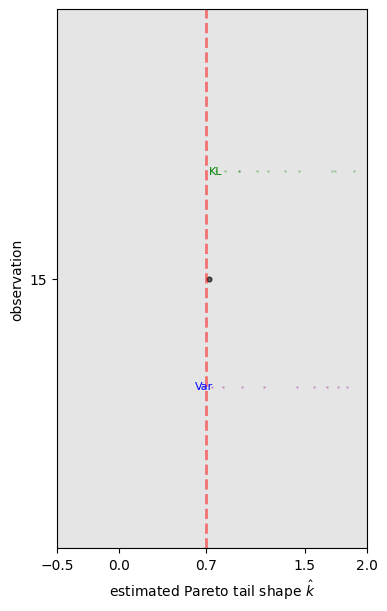

In [28]:
fig = plt.figure(figsize=(4, 7))
ndx_high_khat = loo['KL']['ndx'].tolist()
ymax = (len(ndx_high_khat))
_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]) + 0.2, s=1, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]) - 0.2, s=1, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<3]
ll_ = ll_[ll_.khat<3]
var_ = var_[var_.khat<3]
_ = plt.axvline(x=0.7, linestyle='dashed', linewidth=2, color='red', alpha=0.5)

kl_vals = defaultdict(list)
var_vals = defaultdict(list)
ll_vals = defaultdict(list)

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    kl_vals[y] += [x]
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    var_vals[y] += [x]

for x, v in kl_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)+0.2, color='green', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x) + 0.2, "KL",  ha='center', va='center', color='green', fontsize=8)
    
for x, v in var_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)-0.2, color='purple', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x)-0.2, "Var",  ha='center', va='center', color='blue', fontsize=8)
    
    
#for x, v in var_vals.items():
#    plt.text(min(v), x, "LL",  ha='center', va='center', color='purple', fontsize=8)

_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 2))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
#_ = plt.savefig("khat.pdf", bbox_inches='tight')

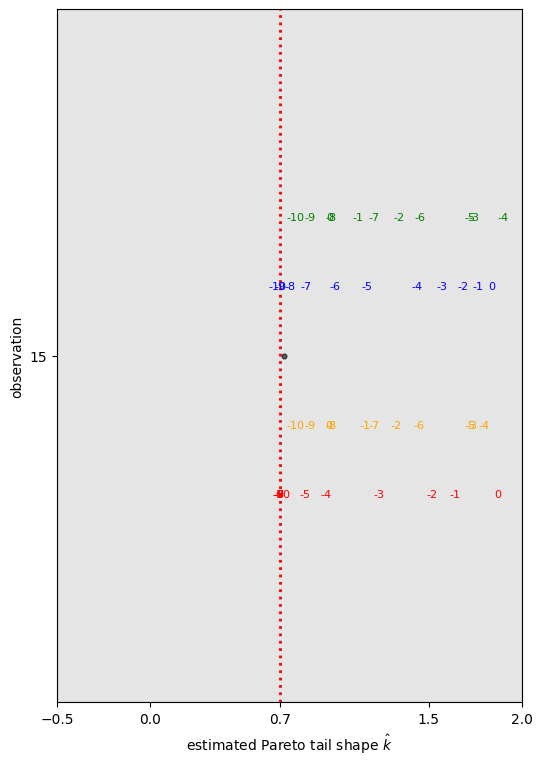

In [29]:
fig = plt.figure(figsize=(6, 9))

_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]), s=0, color='purple', alpha=0.2)
_ = plt.scatter(ll_.khat, np.array([ndx_high_khat.index(i) for i in ll_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(mm1_.khat, np.array([ndx_high_khat.index(i) for i in mm1_['ndx']]), s=0, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<2]
ll_ = ll_[ll_.khat<2]
var_ = var_[var_.khat<2]
mm1_ = mm1_[mm1_.khat<2]
_ = plt.axvline(x=0.7, linestyle='dotted', linewidth=2, color='red')

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.2, str(s),  ha='center', va='center', color='green', fontsize=8)
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.1, str(s),  ha='center', va='center', color='blue', fontsize=8)

for x, y, s in zip( ll_.khat, ll_['ndx'], ll_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.1, str(s),  ha='center', va='center', color='orange', fontsize=8)

for x, y, s in zip( mm1_.khat, mm1_['ndx'], mm1_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.2, str(s),  ha='center', va='center', color='red', fontsize=8)
    
_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 2))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
#_ = plt.savefig("khat_detailed.pdf", bbox_inches='tight')

In [32]:
df_ = df.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_ = df_[df_['T']!="MM2"]

df_ = df_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_ = df_.reset_index()
df_['y'] = [y_.tolist()[i] for i in df_['ndx'].values]


In [35]:
fpr, tpr, thresholds = metrics.roc_curve(df_['y'], df_.p_psis, pos_label=1)
precision, recall, thresholds_pr = metrics.precision_recall_curve(df_['y'], df_.p_psis)

In [37]:
lr_model2 = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [38]:

losses = lr_model2.fit(
    data_factory_factory(shuffle=True, repeat=True),
    dataset_size=N,
    batches_per_step=9,
    check_every=int(N/batch_size)*50,
    batch_size=batch_size,
    num_steps=12000,
    max_decay_steps=10,
    max_plateau_epochs=500,
    sample_size=36,
    learning_rate=0.0005,
    lr_decay_factor=0.9
    )



Running optimization for 12000 steps of 9 accumulated batches, checking every 50 steps
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-1


  0%|          | 49/12000 [00:02<07:14, 27.50it/s] 

Step 50: average-batch loss:223.79298958087338 rel loss: 4.468415216548256e+305
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-2


  1%|          | 97/12000 [00:04<07:15, 27.30it/s]

Step 100: average-batch loss:222.80795078987745 rel loss: 0.0044210217252295715
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-3


  1%|          | 148/12000 [00:06<07:27, 26.46it/s]

Step 150: average-batch loss:221.3726575860752 rel loss: 0.0064836065097342395
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-4


  2%|▏         | 199/12000 [00:08<07:16, 27.06it/s]

Step 200: average-batch loss:221.01830752612958 rel loss: 0.001603261123080215
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-5


  2%|▏         | 247/12000 [00:09<07:04, 27.68it/s]

Step 250: average-batch loss:219.90656423717812 rel loss: 0.0050555257084204126
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-6


  2%|▏         | 298/12000 [00:11<07:08, 27.34it/s]

Step 300: average-batch loss:219.03195494101385 rel loss: 0.003993067113882089
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-7


  3%|▎         | 349/12000 [00:13<07:10, 27.05it/s]

Step 350: average-batch loss:218.11897556728093 rel loss: 0.004185694396181988
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-8


  3%|▎         | 397/12000 [00:15<07:06, 27.20it/s]

Step 400: average-batch loss:217.18568860610347 rel loss: 0.004297184437737536
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-9


  4%|▎         | 448/12000 [00:17<07:02, 27.34it/s]

Step 450: average-batch loss:216.57409890734544 rel loss: 0.0028239281698208708
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-10


  4%|▍         | 499/12000 [00:19<06:59, 27.39it/s]

Step 500: average-batch loss:216.03159755439984 rel loss: 0.002511212984984741
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-11


  5%|▍         | 547/12000 [00:21<07:00, 27.21it/s]

Step 550: average-batch loss:215.5253414049927 rel loss: 0.002348940250398826
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-12


  5%|▍         | 598/12000 [00:23<07:04, 26.86it/s]

Step 600: average-batch loss:214.78756665451536 rel loss: 0.0034349043660616032
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-13


  5%|▌         | 649/12000 [00:24<06:56, 27.23it/s]

Step 650: average-batch loss:214.3392543594981 rel loss: 0.0020916014490995616
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-14


  6%|▌         | 697/12000 [00:26<06:48, 27.67it/s]

Step 700: average-batch loss:213.61854689503 rel loss: 0.003373805668766525
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-15


  6%|▌         | 748/12000 [00:28<06:54, 27.16it/s]

Step 750: average-batch loss:213.3075606689761 rel loss: 0.00145792406550702
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-16


  7%|▋         | 799/12000 [00:30<06:55, 26.95it/s]

Step 800: average-batch loss:212.81815745206296 rel loss: 0.0022996309279830584
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-17


  7%|▋         | 847/12000 [00:32<06:52, 27.04it/s]

Step 850: average-batch loss:212.57256023754815 rel loss: 0.0011553570895526859
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-18


  7%|▋         | 898/12000 [00:34<06:49, 27.10it/s]

Step 900: average-batch loss:212.00944696897906 rel loss: 0.0026560763051821784
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-19


  8%|▊         | 949/12000 [00:36<06:46, 27.17it/s]

Step 950: average-batch loss:211.66547878350516 rel loss: 0.0016250556654338235
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-20


  8%|▊         | 997/12000 [00:37<06:40, 27.50it/s]

Step 1000: average-batch loss:211.4287453390745 rel loss: 0.00111968428914904
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-21


  9%|▊         | 1048/12000 [00:39<06:35, 27.69it/s]

Step 1050: average-batch loss:211.1066885207914 rel loss: 0.001525564256347013
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-22


  9%|▉         | 1099/12000 [00:41<06:36, 27.51it/s]

Step 1100: average-batch loss:210.5992691681622 rel loss: 0.0024094069966787398
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-23


 10%|▉         | 1147/12000 [00:43<06:41, 27.05it/s]

Step 1150: average-batch loss:210.37948192778575 rel loss: 0.0010447180417142844
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-24


 10%|▉         | 1198/12000 [00:45<06:35, 27.35it/s]

Step 1200: average-batch loss:210.27630175238835 rel loss: 0.0004906885585181073
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-25


 10%|█         | 1249/12000 [00:47<06:37, 27.04it/s]

Step 1250: average-batch loss:209.8675346473606 rel loss: 0.001947738632917181
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-26


 11%|█         | 1297/12000 [00:48<06:29, 27.45it/s]

Step 1300: average-batch loss:209.63664302489713 rel loss: 0.0011013896193522467
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-27


 11%|█         | 1348/12000 [00:50<06:30, 27.25it/s]

Step 1350: average-batch loss:209.2626403302123 rel loss: 0.0017872406373859392
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-28


 12%|█▏        | 1399/12000 [00:52<06:28, 27.31it/s]

Step 1400: average-batch loss:209.143568522809 rel loss: 0.0005693304759228176
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-29


 12%|█▏        | 1447/12000 [00:54<06:33, 26.80it/s]

Step 1450: average-batch loss:208.7054291731912 rel loss: 0.002099319367749795
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-30


 12%|█▏        | 1498/12000 [00:56<06:26, 27.19it/s]

Step 1500: average-batch loss:208.50900949408117 rel loss: 0.0009420201054458405
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-31


 13%|█▎        | 1549/12000 [00:58<06:26, 27.05it/s]

Step 1550: average-batch loss:208.46154232628993 rel loss: 0.0002277022766959229
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-32


 13%|█▎        | 1597/12000 [01:00<06:22, 27.23it/s]

Step 1600: average-batch loss:207.84009882292887 rel loss: 0.002990007736141947
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-33


 14%|█▎        | 1648/12000 [01:02<06:19, 27.26it/s]

Step 1650: average-batch loss:207.61886456494364 rel loss: 0.0010655787875962874
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-34


 14%|█▍        | 1699/12000 [01:03<06:20, 27.08it/s]

Step 1700: average-batch loss:207.37815888526717 rel loss: 0.001160708924075451
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-35


 15%|█▍        | 1747/12000 [01:05<06:19, 27.04it/s]

Step 1750: average-batch loss:207.12500091704155 rel loss: 0.001222247276305471
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-36


 15%|█▍        | 1798/12000 [01:07<06:19, 26.89it/s]

Step 1800: average-batch loss:206.69377744990535 rel loss: 0.0020862914813229157
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-37


 15%|█▌        | 1849/12000 [01:09<06:16, 26.97it/s]

Step 1850: average-batch loss:206.6285414850021 rel loss: 0.0003157161369596512
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-38


 16%|█▌        | 1897/12000 [01:11<06:12, 27.14it/s]

Step 1900: average-batch loss:206.2415014234192 rel loss: 0.0018766352015072406
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-39


 16%|█▌        | 1948/12000 [01:13<06:13, 26.95it/s]

Step 1950: average-batch loss:205.9345950383771 rel loss: 0.001490309993738147
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-40


 17%|█▋        | 1999/12000 [01:15<06:09, 27.10it/s]

Step 2000: average-batch loss:205.7151822335251 rel loss: 0.0010665853753220999
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-41


 17%|█▋        | 2047/12000 [01:16<06:11, 26.76it/s]

Step 2050: average-batch loss:205.7249695761123 rel loss: 4.7574888976135396e-05
New learning rate: 0.00045000000000000004


 17%|█▋        | 2098/12000 [01:18<06:06, 27.02it/s]

Step 2100: average-batch loss:205.22895406381963 rel loss: 0.0023691986928621603
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-42


 18%|█▊        | 2149/12000 [01:20<06:04, 27.00it/s]

Step 2150: average-batch loss:205.09300000190967 rel loss: 0.000662889820270269
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-43


 18%|█▊        | 2197/12000 [01:22<06:01, 27.10it/s]

Step 2200: average-batch loss:205.0420846493042 rel loss: 0.0002483165965297092
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-44


 19%|█▊        | 2248/12000 [01:24<05:56, 27.34it/s]

Step 2250: average-batch loss:204.31937934124295 rel loss: 0.0035371353925964513
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-45


 19%|█▉        | 2299/12000 [01:26<05:57, 27.17it/s]

Step 2300: average-batch loss:204.3944025359224 rel loss: 0.00036705112150160074
New learning rate: 0.00040500000000000003


 20%|█▉        | 2347/12000 [01:28<05:53, 27.28it/s]

Step 2350: average-batch loss:203.84027010008205 rel loss: 0.002350415062370474
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-46


 20%|█▉        | 2398/12000 [01:29<05:52, 27.24it/s]

Step 2400: average-batch loss:203.7743303992438 rel loss: 0.0003235917924944262
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-47


 20%|██        | 2449/12000 [01:31<05:52, 27.10it/s]

Step 2450: average-batch loss:203.5042908056746 rel loss: 0.0013269479110249733
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-48


 21%|██        | 2497/12000 [01:33<05:49, 27.16it/s]

Step 2500: average-batch loss:203.21576826735682 rel loss: 0.001419784206598522
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-49


 21%|██        | 2548/12000 [01:35<05:50, 26.98it/s]

Step 2550: average-batch loss:203.2559406370213 rel loss: 0.0001976442584584319
New learning rate: 0.0003645000000000001


 22%|██▏       | 2599/12000 [01:37<05:47, 27.05it/s]

Step 2600: average-batch loss:202.8850221999656 rel loss: 0.0016302143145157603
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-50


 22%|██▏       | 2647/12000 [01:39<05:47, 26.91it/s]

Step 2650: average-batch loss:202.73777183652763 rel loss: 0.0007263094691436857
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-51


 22%|██▏       | 2698/12000 [01:41<05:40, 27.31it/s]

Step 2700: average-batch loss:202.4448823508239 rel loss: 0.0014467616187806647
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-52


 23%|██▎       | 2749/12000 [01:43<05:46, 26.72it/s]

Step 2750: average-batch loss:202.39046367466932 rel loss: 0.0002688796456439946
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-53


 23%|██▎       | 2797/12000 [01:44<05:37, 27.27it/s]

Step 2800: average-batch loss:202.16756911452018 rel loss: 0.0011025238178675532
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-54


 24%|██▎       | 2848/12000 [01:46<05:51, 26.06it/s]

Step 2850: average-batch loss:202.11817137694698 rel loss: 0.0002444002794834097
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-55


 24%|██▍       | 2899/12000 [01:48<05:37, 26.96it/s]

Step 2900: average-batch loss:201.8579304126253 rel loss: 0.0012892283389099412
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-56


 25%|██▍       | 2947/12000 [01:50<05:32, 27.26it/s]

Step 2950: average-batch loss:201.54167367925535 rel loss: 0.0015691877892870076
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-57


 25%|██▍       | 2998/12000 [01:52<05:36, 26.79it/s]

Step 3000: average-batch loss:201.65105317996165 rel loss: 0.0005424196848041343
New learning rate: 0.00032805000000000003


 25%|██▌       | 3049/12000 [01:54<05:29, 27.15it/s]

Step 3050: average-batch loss:201.31213204472775 rel loss: 0.0011402275272540795
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-58


 26%|██▌       | 3097/12000 [01:56<05:29, 26.99it/s]

Step 3100: average-batch loss:201.14181768113568 rel loss: 0.0008467377174748619
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-59


 26%|██▌       | 3148/12000 [01:58<05:26, 27.09it/s]

Step 3150: average-batch loss:201.17429481283094 rel loss: 0.0001614377807337433
New learning rate: 0.000295245


 27%|██▋       | 3199/12000 [01:59<05:32, 26.43it/s]

Step 3200: average-batch loss:200.74945000650916 rel loss: 0.001954514319286009
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-60


 27%|██▋       | 3247/12000 [02:01<05:25, 26.86it/s]

Step 3250: average-batch loss:200.83649797092178 rel loss: 0.00043342701795777417
New learning rate: 0.0002657205


 27%|██▋       | 3298/12000 [02:03<05:22, 27.01it/s]

Step 3300: average-batch loss:200.59151072035024 rel loss: 0.0007873677484742038
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-61


 28%|██▊       | 3349/12000 [02:05<05:18, 27.14it/s]

Step 3350: average-batch loss:200.3322882904217 rel loss: 0.0012939623070283468
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-62


 28%|██▊       | 3397/12000 [02:07<05:18, 27.05it/s]

Step 3400: average-batch loss:200.57193012823234 rel loss: 0.0011947924999147512
New learning rate: 0.00023914845000000005


 29%|██▊       | 3448/12000 [02:09<05:15, 27.09it/s]

Step 3450: average-batch loss:200.2609847272637 rel loss: 0.00035605319356199044
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-63


 29%|██▉       | 3499/12000 [02:11<05:14, 27.00it/s]

Step 3500: average-batch loss:200.08252372804935 rel loss: 0.0008919369662534853
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-64


 30%|██▉       | 3547/12000 [02:12<05:11, 27.13it/s]

Step 3550: average-batch loss:199.83277516090826 rel loss: 0.0012497878135355718
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-65


 30%|██▉       | 3598/12000 [02:14<05:08, 27.21it/s]

Step 3600: average-batch loss:199.78900835354423 rel loss: 0.00021906514139443187
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-66


 30%|███       | 3649/12000 [02:16<05:06, 27.22it/s]

Step 3650: average-batch loss:199.78188976510177 rel loss: 3.5631800514232476e-05
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-67


 31%|███       | 3697/12000 [02:18<05:05, 27.17it/s]

Step 3700: average-batch loss:199.59014759963378 rel loss: 0.0009606795113584927
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-68


 31%|███       | 3748/12000 [02:20<05:03, 27.20it/s]

Step 3750: average-batch loss:199.53098310950233 rel loss: 0.00029651780996328567
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-69


 32%|███▏      | 3799/12000 [02:22<04:57, 27.57it/s]

Step 3800: average-batch loss:199.17969811856034 rel loss: 0.001763658617119157
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-70


 32%|███▏      | 3847/12000 [02:24<05:01, 27.08it/s]

Step 3850: average-batch loss:199.15464072590802 rel loss: 0.00012581877359714889
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-71


 32%|███▏      | 3898/12000 [02:26<05:00, 26.98it/s]

Step 3900: average-batch loss:199.00886355749822 rel loss: 0.0007325159583542335
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-72


 33%|███▎      | 3949/12000 [02:27<04:56, 27.17it/s]

Step 3950: average-batch loss:199.02116952031116 rel loss: 6.18324314072001e-05
New learning rate: 0.00021523360500000005


 33%|███▎      | 3997/12000 [02:29<04:57, 26.91it/s]

Step 4000: average-batch loss:199.01925901158094 rel loss: 5.2233407632781445e-05
New learning rate: 0.00019371024450000004


 34%|███▎      | 4048/12000 [02:31<04:50, 27.34it/s]

Step 4050: average-batch loss:198.88241386041705 rel loss: 0.0006358012990023221
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-73


 34%|███▍      | 4099/12000 [02:33<04:51, 27.06it/s]

Step 4100: average-batch loss:198.76445506163714 rel loss: 0.0005934602278024528
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-74


 35%|███▍      | 4147/12000 [02:35<04:48, 27.20it/s]

Step 4150: average-batch loss:198.69728554053046 rel loss: 0.0003380495154926327
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-75


 35%|███▍      | 4198/12000 [02:37<04:48, 27.00it/s]

Step 4200: average-batch loss:198.52711130707488 rel loss: 0.0008571838492746893
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-76


 35%|███▌      | 4249/12000 [02:39<04:48, 26.90it/s]

Step 4250: average-batch loss:198.42160807258313 rel loss: 0.000531712425459005
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-77


 36%|███▌      | 4297/12000 [02:40<04:44, 27.03it/s]

Step 4300: average-batch loss:198.33312486933517 rel loss: 0.00044613426681122903
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-78


 36%|███▌      | 4348/12000 [02:42<04:44, 26.93it/s]

Step 4350: average-batch loss:198.37204824650186 rel loss: 0.00019621402062819588
New learning rate: 0.00017433922005000006


 37%|███▋      | 4399/12000 [02:44<04:38, 27.30it/s]

Step 4400: average-batch loss:198.20374628240347 rel loss: 0.000652755507190833
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-79


 37%|███▋      | 4447/12000 [02:46<04:34, 27.54it/s]

Step 4450: average-batch loss:198.17541520647126 rel loss: 0.00014295958912308976
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-80


 37%|███▋      | 4498/12000 [02:48<04:36, 27.13it/s]

Step 4500: average-batch loss:197.86889994117976 rel loss: 0.0015490825763048769
Saved a checkpoint: /tmp/tfcheckpoints/6999490a-fd4e-4c79-8bab-11d3308b409c/6999490a-fd4e-4c79-8bab-11d3308b409c-81


 38%|███▊      | 4549/12000 [02:50<04:34, 27.19it/s]

Step 4550: average-batch loss:198.13978823589298 rel loss: 0.0013671574857580541


Terminating because the loss converged


 38%|███▊      | 4550/12000 [02:50<04:38, 26.72it/s]


In [39]:
base = 4
h_vals = [4**-r for r in range(9)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat_advi = {}
    reduced_ndx_advi = {}
    n_sample = [1000]
    records_advi = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(range(fit.stan_variables()['beta0'].shape[0]), size=n_samples, replace=False)
        reduced_ndx_advi[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat_advi[n_samples] = {}
        params_ = lr_model2.sample(n_samples)

        for h in h_vals:
            loo_khat_advi[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model2, batch, params_, h, variational=False)
            reduced_ndx_advi[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "LL", "KL", "Var", "MM1", "MM2"]:
                loo_khat_advi[n_samples][h][T] = np.array(loo[T]["khat"])

                records_advi += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx_advi[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx_advi)

100%|██████████| 1/1 [00:09<00:00,  9.89s/it]

{1000: {1: {'I0': [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70

In [41]:
df_advi = pd.DataFrame(records_advi)
df_advi['rho_rank'] = np.emath.logn(base, df_advi['h']) 

I0_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I0")]

kl_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="KL")]
var_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="Var")]
ll_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="LL")]
mm1_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="MM1")]
I_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I")]

kl_advi = kl_advi.explode(['khat', 'ndx'])
var_advi = var_advi.explode(['khat', 'ndx'])
ll_advi = ll_advi.explode(['khat', 'ndx'])
I_advi = I_advi.explode(['khat', 'ndx'])
mm1_advi = mm1_advi.explode(['khat', 'ndx'])

original_advi = I_advi[['khat', 'ndx']].drop_duplicates()


In [44]:
df_advi_ = df_advi.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_advi_ = df_advi_[df_advi_['T']!="MM2"]

df_advi_ = df_advi_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_advi_ = df_advi_.reset_index()
df_advi_['y'] = [y_.tolist()[i] for i in df_advi_['ndx'].values]

In [45]:
fpr_advi, tpr_advi, thresholds_advi = metrics.roc_curve(df_advi_['y'], df_advi_.p_psis, pos_label=1)
precision_advi, recall_advi, thresholds_pr_advi = metrics.precision_recall_curve(df_advi_['y'], df_advi_.p_psis)

(0.0, 1.0)

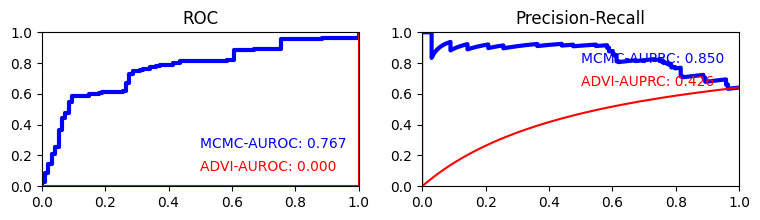

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(fpr, tpr, linewidth=3, color="blue")
ax[0].text(0.5, 0.25, f"MCMC-AUROC: {metrics.auc(fpr, tpr):.3f}", color="blue")

ax[0].plot(fpr_advi, tpr_advi, color="red")
ax[0].text(0.5, 0.1, f"ADVI-AUROC: {metrics.auc(fpr_advi, tpr_advi):.3f}", color="red")

ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(recall, precision, linewidth=3, color="blue")
ax[1].plot(recall_advi, precision_advi, color="red")
ax[1].text(0.5, 0.8, f"MCMC-AUPRC: {metrics.auc(recall, precision):.3f}", color="blue")
ax[1].text(0.5, 0.65, f"ADVI-AUPRC: {metrics.auc(recall_advi, precision_advi):.3f}", color="red")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

#_ = plt.savefig("roccurve.pdf", bbox_inches='tight')